In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import scipy as sp

from tqdm import tqdm

import Volterros
import matplotlib.pyplot as plt

key = random.PRNGKey(0)

In [2]:
ALPHA = 1.0
BETA = 0.7
V = 2000
D = 500
SGDBATCH=1
STEPS = 10**6

In [3]:
key, subkey = random.split(key)
problem = Volterros.power_law_RF.initialize_random(alpha=ALPHA, beta=BETA, v=V, d=D, key=subkey)


In [4]:
g1 = Volterros.powerlaw_schedule(1.0, 0.0, 0.0, 1)
g2 = Volterros.powerlaw_schedule(0.5/problem.population_trace, 0.0, 0.0, 1)
g3 = Volterros.powerlaw_schedule(0.1/problem.population_trace, 0.0, -1.0/(2*problem.alpha), 1)
Delta = Volterros.powerlaw_schedule(1.0, 0.0, -1.0, 4.0+2*(problem.alpha+problem.beta)/(2*problem.alpha))
danadecayopt = Volterros.dana_optimizer(g1=g1,g2=g2,g3=g3,Delta=Delta)
#pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
key, newkey = random.split(key)
danadecaytimes,danadecaylosses = Volterros.lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         SGDBATCH, 
                         STEPS, 
                         danadecayopt, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 130/130 [01:06<00:00,  1.94it/s]


In [5]:
#Initialize the rhos
initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
initY = jnp.zeros(problem.d, dtype=jnp.float32)
rho_init = problem.get_rhos()
sigma_init = jnp.zeros_like(rho_init)
chi_init = jnp.zeros_like(rho_init)

Keigs = problem.get_hessian_spectra()
riskInftyTheory=problem.get_theory_limitloss()

Dt = 10**(-2)

odeTimes_dana_decay2, odeRisks_dana_decay2 = Volterros.ode_resolvent_log_implicit_full(
    Keigs.astype(jnp.float32), rho_init, chi_init, sigma_init, riskInftyTheory,
    g1, g2, g3, Delta, 
    SGDBATCH, problem.d, STEPS, Dt)


In [6]:

#Compute the theoretical limiting loss value
riskInftyTheory = Volterros.power_law_RF.theory_limitloss(ALPHA, BETA, V, D)
print('Theoretical limiting loss value is {}'.format(riskInftyTheory))

# Compute theoretical integrals using density approximation
lower_bound = Volterros.power_law_RF.theory_lambda_min(ALPHA)*(D**(-2*ALPHA)) #jnp.minimum(0.00001, 0.9*(D+1)**(-2.0*alpha)) #tt_lmin(alpha)*(D**(-2*alpha)) #jnp.minimum(0.00001, 0.9*(D+1)**(-2.0*alpha))
upper_bound = 1.0*1.1


fake_eigs = jnp.power(jnp.arange(1,D+1,dtype=jnp.float32),-2.0*ALPHA)
b_values = fake_eigs - 0.5 * jnp.diff(fake_eigs, prepend = upper_bound)
a_values = fake_eigs + 0.5 * jnp.diff(fake_eigs, append = lower_bound)


num_splits = 5
rho_weights = problem.get_theory_rho_weights(num_splits, a_values, b_values)

print('Initial loss value is is {}'.format(jnp.sum( rho_weights*fake_eigs) + riskInftyTheory))


rho_init = rho_weights #density * dx
num_grid_points = D
sigma_init = jnp.zeros(num_grid_points, dtype=jnp.float32)
chi_init = jnp.zeros(num_grid_points, dtype=jnp.float32)

Dt = 10**(-2) #10**(-2)


odeTimes_dana_decay_theory, odeRisks_dana_decay_theory = Volterros.ode_resolvent_log_implicit_full(
    fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory,
    g1, g2, g3, Delta, SGDBATCH, num_grid_points, STEPS, Dt)

Theoretical limiting loss value is 2.2151918528834358e-05
Initial loss value is is 0.9775581955909729


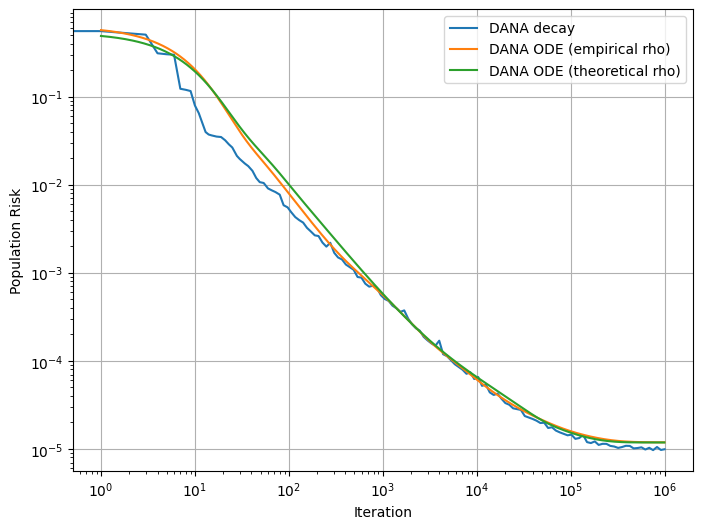

In [7]:
plt.figure(figsize=(8,6))
plt.loglog(danadecaytimes,danadecaylosses,label='DANA decay')
plt.loglog(odeTimes_dana_decay2, odeRisks_dana_decay2, label='DANA ODE (empirical rho)')
plt.loglog(odeTimes_dana_decay_theory, odeRisks_dana_decay_theory, label='DANA ODE (theoretical rho)')
plt.xlabel('Iteration')
plt.ylabel('Population Risk')
plt.legend()
plt.grid(True)

In [8]:
adamopt = optax.adam(learning_rate=0.001)
#pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
key, newkey = random.split(key)
adamtimes,adamlosses = Volterros.lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         SGDBATCH, 
                         STEPS, 
                         adamopt, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 130/130 [01:03<00:00,  2.04it/s]


In [14]:
cos_decay = optax.cosine_decay_schedule(init_value=0.01, decay_steps=STEPS)
adam_cos_decay = optax.adam(learning_rate=cos_decay)
#pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
key, newkey = random.split(key)
adam_cos_decay_times,adam_cos_decay_losses = Volterros.lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         SGDBATCH, 
                         STEPS, 
                         adam_cos_decay, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 130/130 [01:03<00:00,  2.04it/s]


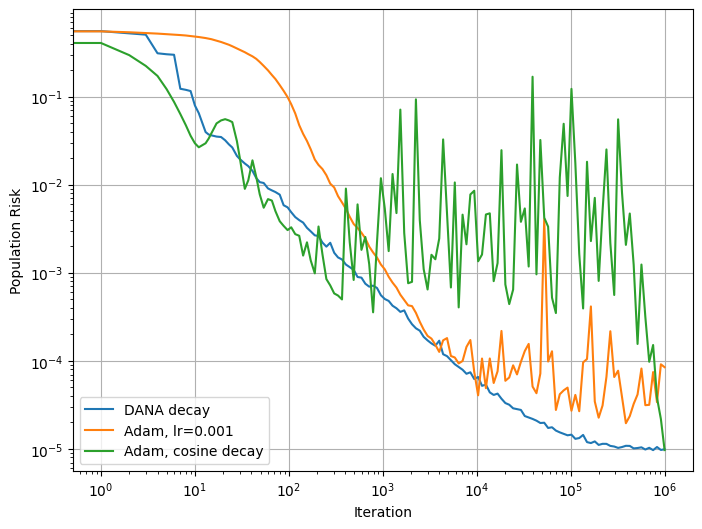

In [15]:
plt.figure(figsize=(8,6))
plt.loglog(danadecaytimes,danadecaylosses,label='DANA decay')
plt.loglog(adamtimes,adamlosses,label='Adam, lr=0.001')
plt.loglog(adam_cos_decay_times,adam_cos_decay_losses,label='Adam, cosine decay')
plt.xlabel('Iteration')
plt.ylabel('Population Risk')
plt.legend()
plt.grid(True)